# Business Understanding

**Author:** Frauke Albrecht

<div>
<img src="fake_news_1.jpg" width="500"/>
</div>

**Objective:** Detecting fake news and categorize them in German language

So called fake news are news that are made up to manipulate people. This strategy is aminly used in the internet and in social media. In today's flood of information it becomes more and more difficult to distinguish fake from real news. An instrument to detect them automatically can help users to filter and classify the information they get. These algorithms are language sensitive and therefore must be developed for each language separately. In this work we consider news in German Language. The dataset contains news from German and Austrian newspapers' websites.
An attempt was made to build a machine learning model that detects fake news and a second one which also categorizes them in a certain column. The dataset contains real news and news from satire magazines. The latter can serve to detect fake news as they are similar in their structure.

The work has been inspired by: https://medium.com/@andreasstckl/detecting-satire-and-fake-news-with-machine-learning-435695749f79


# Setup

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from datetime import datetime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import precision_recall_curve, confusion_matrix, accuracy_score, classification_report, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Data Mining

Source: https://www.kaggle.com/astoeckl/fake-news-dataset-german

# Data Cleaning

Read the data and have a look at the head and the tail of the dataframe. The dataframe conatins 8 columns: 
**url, Titel, Body, Kategorie, Datum, Quelle, Fake and Art** and a total number of 63868 rows. There are 1322 missing values in the column "Kategorie" and 40972 in the column "Art". Have a further look at the entries to decide how to treat the missing values. The entry "Titel" shows doubled entries, further inspection of these show that the entries are identical in the dataframe. These entries are thus deleted. The column "Kategorie" is not well defined, we rename misslabeled entries. The meaning of the column "Art" is not clear, since it has a lot of missing values, we  won't use it for the predictions and therefore delete it.


In [158]:
# read the data
news = pd.read_csv("news.csv", sep=',',index_col = "id")
print(news.shape)
news.head()

(63868, 8)


,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Art
id,,,,,,,,
773233,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,wirtschaft,2018-01-18 00:00:00,Postillion,1,NaN
773234,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,wirtschaft,2018-01-17 00:00:00,Postillion,1,NaN
773235,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",wirtschaft,2018-01-12 00:00:00,Postillion,1,NaN
773236,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,wirtschaft,2018-01-09 00:00:00,Postillion,1,NaN
773237,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,wirtschaft,2018-01-08 00:00:00,Postillion,1,NaN


In [159]:
news.tail()

,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Art
id,,,,,,,,
838144,http://www.kleinezeitung.at//international/537...,Lehrer entging durch Hochzeit mit Schülerin Ve...,55-Jähriger muss nach Sex mit damals 15-Jährig...,International,2018-02-26 00:00:00,Kleine,0,NaN
838145,http://www.kleinezeitung.at//wirtschaft/wirtsc...,Warum die Taiwaner Toilettenpapier bunkern,Aus Angst vor Preiserhöhungen bei Klopapier ka...,Wirtschaft,2018-02-26 00:00:00,Kleine,0,NaN
838146,http://www.kleinezeitung.at//wirtschaft/wirtsc...,Warum die Taiwaner Toilettenpapier bunkern,Aus Angst vor Preiserhöhungen bei Klopapier ka...,Wirtschaft,2018-02-26 00:00:00,Kleine,0,NaN
838147,http://www.kleinezeitung.at//wirtschaft/wirtsc...,\r\nDie neue Premium-Klasse von Samsung\r\n ...,Am Vorabend der Eröffnung des Mobile World Con...,Wirtschaft,2018-02-25 00:00:00,Kleine,0,NaN
838148,http://www.kleinezeitung.at//kultur/klassik/53...,"Dirigent Gustav Kuhn wehrt sich gegen ""haltlos...","Gustav Kuhn, künstlerischer Leiter der Festspi...",Kultur,2018-02-26 00:00:00,Kleine,0,NaN


In [160]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63868 entries, 773233 to 838148
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        63868 non-null  object
 1   Titel      63868 non-null  object
 2   Body       63868 non-null  object
 3   Kategorie  62546 non-null  object
 4   Datum      63868 non-null  object
 5   Quelle     63868 non-null  object
 6   Fake       63868 non-null  int64 
 7   Art        22896 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.4+ MB


In [161]:
# number of missing values in each column
news.isna().sum()

url              0
Titel            0
Body             0
Kategorie     1322
Datum            0
Quelle           0
Fake             0
Art          40972
dtype: int64

In [162]:
news.reset_index(inplace=True)

In [163]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["url"].unique())))
news["url"].unique()

Length of unique values:63868


array(['http://www.der-postillon.com/2018/01/grokoleaks.html',
       'http://www.der-postillon.com/2018/01/trump-sane.html',
       'http://www.der-postillon.com/2018/01/fdp-sondierungen.html', ...,
       'http://www.kleinezeitung.at//wirtschaft/wirtschaftaufmacher/5378930/Papierpreise_Warum-die-Taiwaner-Toilettenpapier-bunkern',
       'http://www.kleinezeitung.at//wirtschaft/wirtschaftktnhp/5378354/Die-neue-PremiumKlasse-von-Samsung_Galaxy-S9-und-S9',
       'http://www.kleinezeitung.at//kultur/klassik/5378972/Causa-Festspiele-Erl_Dirigent-Gustav-Kuhn-wehrt-sich-gegen'],
      dtype=object)

In [164]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["Titel"].unique())))
news["Titel"].unique()

Length of unique values:61437


array(['Exklusiv! Das geheime WhatsApp-Chat-Protokoll der GroKo-Sondierungsgespräche',
       'Trump droht, jeden zu verspeisen, der an seiner geistigen Gesundheit zweifelt',
       'Soli runter, keine Steuererhöhungen, kein Klimaziel! FDP setzt sich in Sondierungen durch',
       ..., 'Warum die Taiwaner Toilettenpapier bunkern',
       '\r\nDie neue Premium-Klasse von Samsung\r\n            Galaxy S9 und S9+',
       'Dirigent Gustav Kuhn wehrt sich gegen "haltlose Anschuldigungen"'],
      dtype=object)

In [165]:
# there are several entries with the same titel, delete duplicated entries
news.drop_duplicates(inplace=True)
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63868 entries, 0 to 63867
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         63868 non-null  int64 
 1   url        63868 non-null  object
 2   Titel      63868 non-null  object
 3   Body       63868 non-null  object
 4   Kategorie  62546 non-null  object
 5   Datum      63868 non-null  object
 6   Quelle     63868 non-null  object
 7   Fake       63868 non-null  int64 
 8   Art        22896 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.9+ MB


In [166]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["Kategorie"].unique())))
news["Kategorie"].unique()

Length of unique values:35


array(['wirtschaft', 'sport', 'leute', 'medien', 'wissenschaft',
       'panorama', 'Weltnachrichten', 'Inlandsnachrichten',
       'Unternehmensnachrichten', 'Wirtschaftsnachrichten',
       'Marktnachrichten', 'Top-Nachrichten', 'Politik',
       'nlandsnachrichten', 'irtschaftsnachrichten', 'eltnachrichten',
       'nternehmensnachrichten', 'arktnachrichten', 'op-Nachrichten',
       'Wirtschaft', 'Chronik', 'International', 'Kultur', 'Wissen',
       'Gesundheit', 'Panorama', nan, 'LEBEN', 'MEDIEN', 'BUSINESS',
       'HIGHTECH', 'ADHOC', 'Österreich', 'Sport', 'Leute'], dtype=object)

In [167]:
## MAKE THIS NICER!

# change names in "Kategorie"

for i in range(news.shape[0]):
    #print(news.loc[i,"Kategorie"])
    if (news.loc[i,"Kategorie"] == 'wirtschaft') or (news.loc[i,"Kategorie"] =='Wirtschaftsnachrichten') or (news.loc[i,"Kategorie"] == 'irtschaftsnachrichten'):
        news.loc[i,"Kategorie"] = 'Wirtschaft'
    if news.loc[i,"Kategorie"] == 'sport':
        news.loc[i,"Kategorie"] = 'Sport'
    if news.loc[i,"Kategorie"] == 'leute':
        news.loc[i,"Kategorie"] = 'Leute'
    if (news.loc[i,"Kategorie"] == 'medien') or (news.loc[i,"Kategorie"] == 'MEDIEN'):
        news.loc[i,"Kategorie"] = 'Medien'
    if (news.loc[i,"Kategorie"] == 'wissenschaft') or (news.loc[i,"Kategorie"] == 'Wissen'):
        news.loc[i,"Kategorie"] = 'Wissenschaft'
    if news.loc[i,"Kategorie"] == 'panorama':
        news.loc[i,"Kategorie"] = 'Panorama'
    if news.loc[i,"Kategorie"] == 'wirtschaft':
        news.loc[i,"Kategorie"] = 'Wirtschaft'
    if (news.loc[i,"Kategorie"] == 'nlandsnachrichten') or (news.loc[i,"Kategorie"] == 'Inlandsnachrichten'):
        news.loc[i,"Kategorie"] = 'Inland'
    if news.loc[i,"Kategorie"] == 'eltnachrichten':
        news.loc[i,"Kategorie"] = 'Weltnachrichten'
    if (news.loc[i,"Kategorie"] == 'nternehmensnachrichten') or (news.loc[i,"Kategorie"] == 'BUSINESS') or (news.loc[i,"Kategorie"] == 'Unternehmensnachrichten'): 
        news.loc[i,"Kategorie"] = 'Business'
    if news.loc[i,"Kategorie"] == 'arktnachrichten':
        news.loc[i,"Kategorie"] = 'Marktnachrichten'
    if news.loc[i,"Kategorie"] == 'op-Nachrichten':
        news.loc[i,"Kategorie"] = 'Top-Nachrichten'
    if news.loc[i,"Kategorie"] == 'LEBEN':
        news.loc[i,"Kategorie"] = 'Leben'
    if news.loc[i,"Kategorie"] == 'HIGHTECH':
        news.loc[i,"Kategorie"] = 'Hightech'
    if news.loc[i,"Kategorie"] == 'ADHOC':
        news.loc[i,"Kategorie"] = 'Adhock'
    if news.loc[i,"Kategorie"] == 'Weltnachrichten':
        news.loc[i,"Kategorie"] = 'International'
print("Length of unique values:" + str(len(news["Kategorie"].unique())))
news["Kategorie"].unique()    

Length of unique values:20


array(['Wirtschaft', 'Sport', 'Leute', 'Medien', 'Wissenschaft',
       'Panorama', 'International', 'Inland', 'Business',
       'Marktnachrichten', 'Top-Nachrichten', 'Politik', 'Chronik',
       'Kultur', 'Gesundheit', nan, 'Leben', 'Hightech', 'Adhock',
       'Österreich'], dtype=object)

In [168]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["Datum"].unique())))
news["Datum"].unique()

Length of unique values:3482


array(['2018-01-18 00:00:00', '2018-01-17 00:00:00',
       '2018-01-12 00:00:00', ..., '2018-03-02 00:00:00',
       '2018-02-17 00:00:00', '2018-02-03 00:00:00'], dtype=object)

In [169]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["Quelle"].unique())))
news["Quelle"].unique()

Length of unique values:7


array(['Postillion', 'Reuters', 'Tagespresse', 'Zeitspiegel',
       'Einezeitung', 'Pressetext', 'Kleine'], dtype=object)

In [170]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["Fake"].unique())))
news["Fake"].unique()

Length of unique values:2


array([1, 0])

In [171]:
# have a look at the entries of the columns and the number of unique values
print("Length of unique values:" + str(len(news["Art"].unique())))
news["Art"].unique()

Length of unique values:6


array([nan, 'pte', 'pts', 'pta', 'ptp', 'None'], dtype=object)

In [172]:
# drop column "Art"
news.drop(["Art"],axis=1, inplace=True)
news.head()

,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake
0,773233,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,Wirtschaft,2018-01-18 00:00:00,Postillion,1
1,773234,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,Wirtschaft,2018-01-17 00:00:00,Postillion,1
2,773235,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",Wirtschaft,2018-01-12 00:00:00,Postillion,1
3,773236,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,Wirtschaft,2018-01-09 00:00:00,Postillion,1
4,773237,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,Wirtschaft,2018-01-08 00:00:00,Postillion,1


# Data Exploration

## Explore the column "Kategorie"

Plot the number of articles for each category. Then explore which source has which category. It turns out that "Einezeitung" doesn't have any category. For the prediction of fake news without predicting the category this is not important. We will therefore make a copy of the existing dataframe for the purpose of our first obl´jective, which is to build a model that detects fake news. For the purpose of our second objective, that is also predicting the category, we need to delete entries from "Einezeitung". This leaves us with two dataframes, the first one has only missing values in the column "Kategorie", which is not important, and the second does not have any missing values.

For the prediction of the category, we will only keep the most importants: **Wirtschaft, Sport, Medien, International, Inland, Business, Leben, Hightech, Politik** and combine the others to the category **"Andere"**. "Politik" and "Sport" have comparable little values. We will have to see, if we can keep them for predicting.

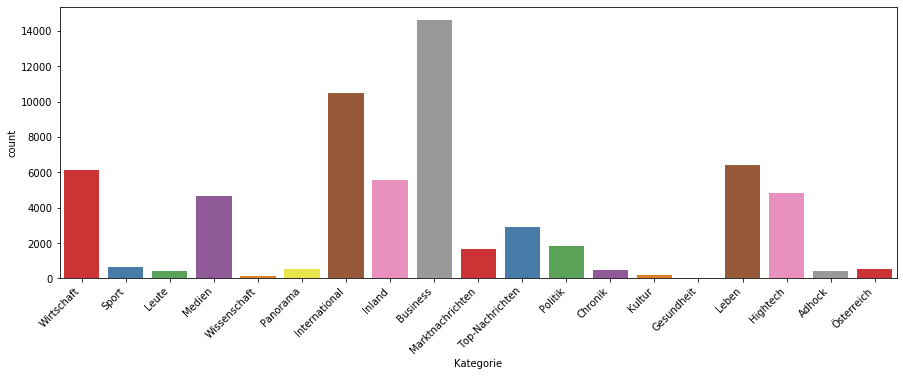

In [173]:
# number of articles per category
plt.figure(figsize=(15,5))
chart = sns.countplot(news["Kategorie"],palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [174]:
# Which category has which source?
news.groupby(["Quelle"])["Kategorie"].unique()

Quelle
Einezeitung                                                [nan]
Kleine         [Österreich, International, Sport, Politik, Wi...
Postillion     [Wirtschaft, Sport, Leute, Medien, Wissenschaf...
Pressetext           [Leben, Medien, Business, Hightech, Adhock]
Reuters        [International, Inland, Business, Wirtschaft, ...
Tagespresse        [Wirtschaft, Politik, Chronik, International]
Zeitspiegel    [Politik, Wirtschaft, Kultur, Wissenschaft, Ge...
Name: Kategorie, dtype: object

In [175]:
# Copy the existing dataframe for the model, which only predicts whether the news are fake or not
# (In this case the category is not important)
news_fake = news.copy()
news_fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63868 entries, 0 to 63867
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         63868 non-null  int64 
 1   url        63868 non-null  object
 2   Titel      63868 non-null  object
 3   Body       63868 non-null  object
 4   Kategorie  62546 non-null  object
 5   Datum      63868 non-null  object
 6   Quelle     63868 non-null  object
 7   Fake       63868 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.4+ MB


In [176]:
# The source "Einezeitung" does not have categories
# For the prediction of the category me need to remove these values

news_cat = news.copy()
news_cat.drop(news_cat[news_cat["Quelle"] == "Einezeitung"].index, inplace=True)
news_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62546 entries, 0 to 63867
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         62546 non-null  int64 
 1   url        62546 non-null  object
 2   Titel      62546 non-null  object
 3   Body       62546 non-null  object
 4   Kategorie  62546 non-null  object
 5   Datum      62546 non-null  object
 6   Quelle     62546 non-null  object
 7   Fake       62546 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.3+ MB


In [177]:
# only keep categories: Wirtschaft, Sport, Medien, International, Inland, Business, Leben, Hightech, Politik
# combine all others to category "Andere"
news_cat['Kategorie'] = np.where(news_cat.isin(["Leute","Wissenschaft","Panorama"
                                                ,"Marktnachrichten","Top-Nachrichten","Chronik"
                                                ,"Kultur","Gesundheit","Adhock","Österreich"])["Kategorie"]
                                , "Andere", news_cat['Kategorie'])

In [178]:
print("Length of unique values:" + str(len(news_cat["Kategorie"].unique())))
news_cat["Kategorie"].unique()

Length of unique values:10


array(['Wirtschaft', 'Sport', 'Andere', 'Medien', 'International',
       'Inland', 'Business', 'Politik', 'Leben', 'Hightech'], dtype=object)

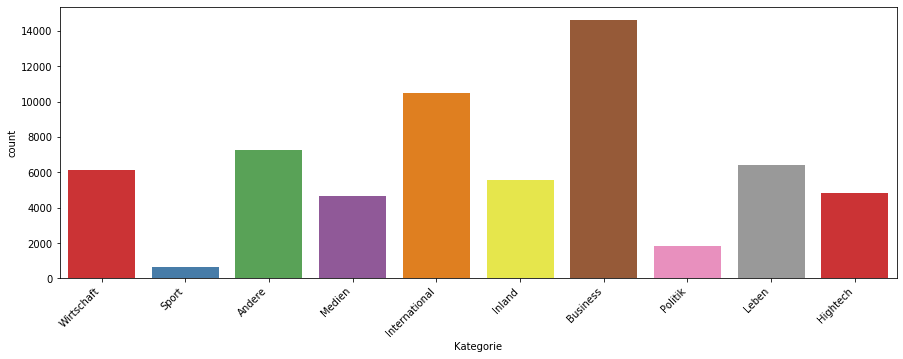

In [179]:
# number of articles per category
plt.figure(figsize=(15,5))
chart = sns.countplot(news_cat["Kategorie"],palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [180]:
# Was bedeuten die einzelnen Kategorien? Können noch weitere Zusammengefasst werden?

#Leben -> (Promis) speziell von "kleine Zeitung" -> Andere
#Panorama -> gesellschaftlichen Themen
#Kleine Zeitung: aus Österreich, hat keine Rubrik Inland
#Postillon, keine Rubrik Inland
#Reuters: Inland = Deutschland
#Tagespresse (Österreich): kein Inland

## Exploration of Statistics in the Dataset

### Fake versus no Fake

For the fake vs. no fake analsysis we have a look at the number of articles that are listed as fake and those that are listed as no fake. We can see that there are much more real (no fake) articles. That is the distribution is not balanced.

In [181]:
#count nr of fake vs. no fake articles 
news_fake.groupby(["Fake"]).count()

,id,url,Titel,Body,Kategorie,Datum,Quelle
Fake,,,,,,,
0,59241,59241,59241,59241,59241,59241,59241
1,4627,4627,4627,4627,3305,4627,4627


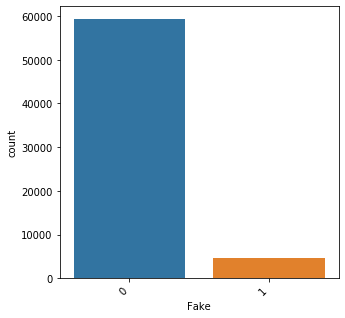

In [182]:

plt.figure(figsize=(5,5))
chart = sns.countplot(x='Fake', data=news_fake);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [183]:
news_fake.reset_index(inplace=True)

### Categories

By deleting the source "Einezeitung", we lost articles of the category fake, so that the distribution is now even more imbalanced considering fake vs. no fake articles. Looking at the number of articles per category also shows imbalances. Especially the categories "Sport" and "Politik" have little data. Considering the mean length of the articles, this is quite equal over all categories.

In [184]:
#count nr of fake vs. no fake articles 
news_cat.groupby(["Fake"]).count()

,id,url,Titel,Body,Kategorie,Datum,Quelle
Fake,,,,,,,
0,59241,59241,59241,59241,59241,59241,59241
1,3305,3305,3305,3305,3305,3305,3305


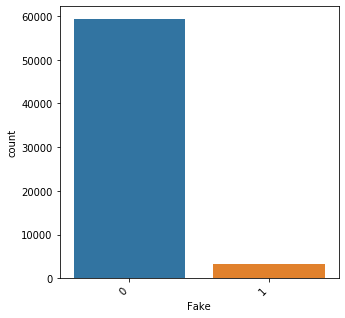

In [185]:
plt.figure(figsize=(5,5))
chart = sns.countplot(x='Fake', data=news_cat);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [186]:
#count nr of articles per category
news_cat.groupby(["Kategorie"]).count()

,id,url,Titel,Body,Datum,Quelle,Fake
Kategorie,,,,,,,
Andere,7236,7236,7236,7236,7236,7236,7236
Business,14635,14635,14635,14635,14635,14635,14635
Hightech,4842,4842,4842,4842,4842,4842,4842
Inland,5577,5577,5577,5577,5577,5577,5577
International,10485,10485,10485,10485,10485,10485,10485
Leben,6436,6436,6436,6436,6436,6436,6436
Medien,4683,4683,4683,4683,4683,4683,4683
Politik,1836,1836,1836,1836,1836,1836,1836
Sport,660,660,660,660,660,660,660


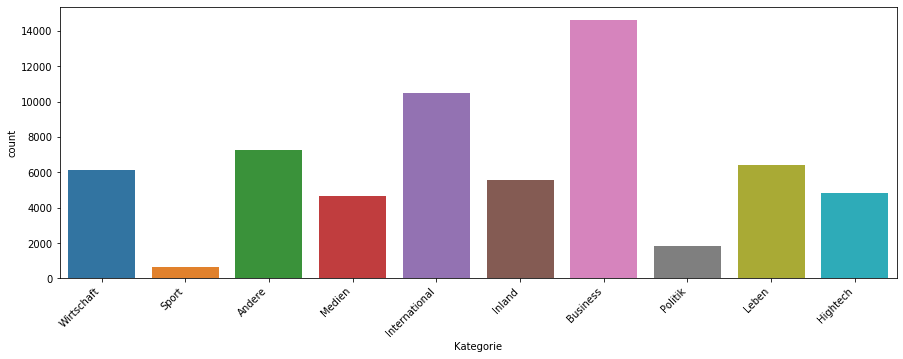

In [187]:
plt.figure(figsize=(15,5))
chart = sns.countplot(x='Kategorie', data=news_cat);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
#chart = news_cat['Kategorie'].value_counts().plot(kind='bar')
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [188]:
news_cat.reset_index(inplace=True)

### Average number of Words in each Category

Count the number of words in each article and mean over the categories. The result range between 298 and 378.

In [189]:
#count nr of words in articles 
for i in range(news_cat.shape[0]):
    news_cat.loc[i,"Body_length"] = len(news_cat.loc[i,"Body"].split())

In [190]:
news_cat.head()

,index,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Body_length
0,0,773233,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,Wirtschaft,2018-01-18 00:00:00,Postillion,1,160.0
1,1,773234,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,Wirtschaft,2018-01-17 00:00:00,Postillion,1,248.0
2,2,773235,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",Wirtschaft,2018-01-12 00:00:00,Postillion,1,264.0
3,3,773236,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,Wirtschaft,2018-01-09 00:00:00,Postillion,1,290.0
4,4,773237,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,Wirtschaft,2018-01-08 00:00:00,Postillion,1,163.0


In [191]:
#mean number of words per category
mean_words = pd.DataFrame(round(news_cat.groupby(["Kategorie"])["Body_length"].mean(),0))
mean_words.reset_index(inplace=True)
mean_words.head()

,Kategorie,Body_length
0,Andere,313.0
1,Business,365.0
2,Hightech,378.0
3,Inland,338.0
4,International,298.0


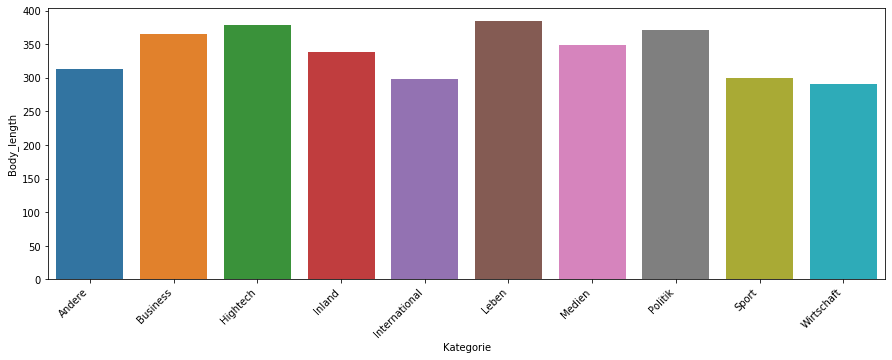

In [192]:
plt.figure(figsize=(15,5))
chart = sns.barplot(x=mean_words["Kategorie"],y=mean_words["Body_length"]);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

### Wordclouds for each Category

Create wordclouds for the texts separated by categories.

In [193]:
#which words occur in which category? -> Word clouds for each category
#get words in a category
def get_words(category):
    text_df = pd.DataFrame(news_cat[news_cat["Kategorie"] == category]["Body"]) 
    text = [text_df.iloc[i,:]["Body"] for i in range(text_df.shape[0])]
    text_full = ''
    for i in range(len(text)):
        text_full += text[i]
    return text_full

In [194]:
#get words for each category
text_andere        = get_words("Andere")
text_business      = get_words("Business")
text_hightech      = get_words("Hightech")
text_inland        = get_words("Inland")
text_international = get_words("International")
text_leben         = get_words("Leben")
text_medien        = get_words("Medien")
text_politik       = get_words("Politik")
text_sport         = get_words("Sport")
text_wirtschaft    = get_words("Wirtschaft")

In [195]:
#clean text
#delete punctuation marks, all lower case
text_business      = text_business.lower()
text_hightech      = text_hightech.lower()
text_inland        = text_inland.lower()
text_international = text_international.lower()
text_leben         = text_leben.lower()
text_medien        = text_medien.lower()
text_politik       = text_politik.lower()
text_sport         = text_sport.lower()
text_wirtschaft    = text_wirtschaft.lower()

In [196]:
#get the single words, without puncuation
words_business      = re.split(r'\W+', text_business)
words_hightech      = re.split(r'\W+', text_hightech)
words_inland        = re.split(r'\W+', text_inland)
words_international = re.split(r'\W+', text_international)
words_leben         = re.split(r'\W+', text_leben)
words_medien        = re.split(r'\W+', text_medien)
words_politik       = re.split(r'\W+', text_politik)
words_sport         = re.split(r'\W+', text_sport)
words_wirtschaft    = re.split(r'\W+', text_wirtschaft)

In [197]:
text_clear_business      = ' '.join(words_business)
text_clear_hightech      = ' '.join(words_hightech)
text_clear_inland        = ' '.join(words_inland)
text_clear_international = ' '.join(words_international)
text_clear_leben         = ' '.join(words_leben)
text_clear_medien        = ' '.join(words_medien)
text_clear_politik       = ' '.join(words_politik)
text_clear_sport         = ' '.join(words_sport)
text_clear_wirtschaft    = ' '.join(words_wirtschaft)

In [198]:
#define a mask

#The way the masking functions works is that it requires all white part of the mask should be 255 not 0 
#(integer type). This value represents the "intensity" of the pixel. Values of 255 are pure white, 
#whereas values of 1 are black. Here, you can use the provided function below to transform your mask 
#if your mask has the same format as above. Notice if you have a mask that the background is not 0, but 1 or 2, 
#adjust the function to match your mask.
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val



def gen_mask(mask):

    # Transform your mask into a new one that will work with the function:
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

    for i in range(len(mask)):
        transformed_mask[i] = list(map(transform_format, mask[i]))
    return transformed_mask

In [199]:
# Define masks for each category
# we have 9 categories (except "Andere")

#Business
#business_mask = np.array(Image.open("Images/business1.png"))
business_mask = np.array(Image.open("Images/business2.png"))
#business_mask = np.array(Image.open("Images/business3.png"))
#Hightech
hightech_mask = np.array(Image.open("Images/business1.png"))
#Inland
inland_mask = np.array(Image.open("Images/inland4.png"))
#International
international_mask = np.array(Image.open("Images/international1.png"))
#Leben
leben_mask = np.array(Image.open("Images/international1.png"))
#Medien
medien_mask = np.array(Image.open("Images/international1.png"))
#Politik
politik_mask = np.array(Image.open("Images/international1.png"))
#Sport
sport_mask = np.array(Image.open("Images/sport3.png"))
#Wirtschaft
wirtschaft_mask = np.array(Image.open("Images/international1.png"))

#transform masks for wordclouds
transformed_business_mask      = gen_mask(business_mask)
transformed_hightech_mask      = gen_mask(hightech_mask)
transformed_inland_mask        = inland_mask#gen_mask(inland_mask)
transformed_international_mask = international_mask#gen_mask(international_mask)
transformed_leben_mask         = leben_mask
transformed_medien_mask        = medien_mask
transformed_politik_mask       = politik_mask
transformed_sport_mask         = gen_mask(sport_mask)
transformed_wirtschaft_mask    = wirtschaft_mask

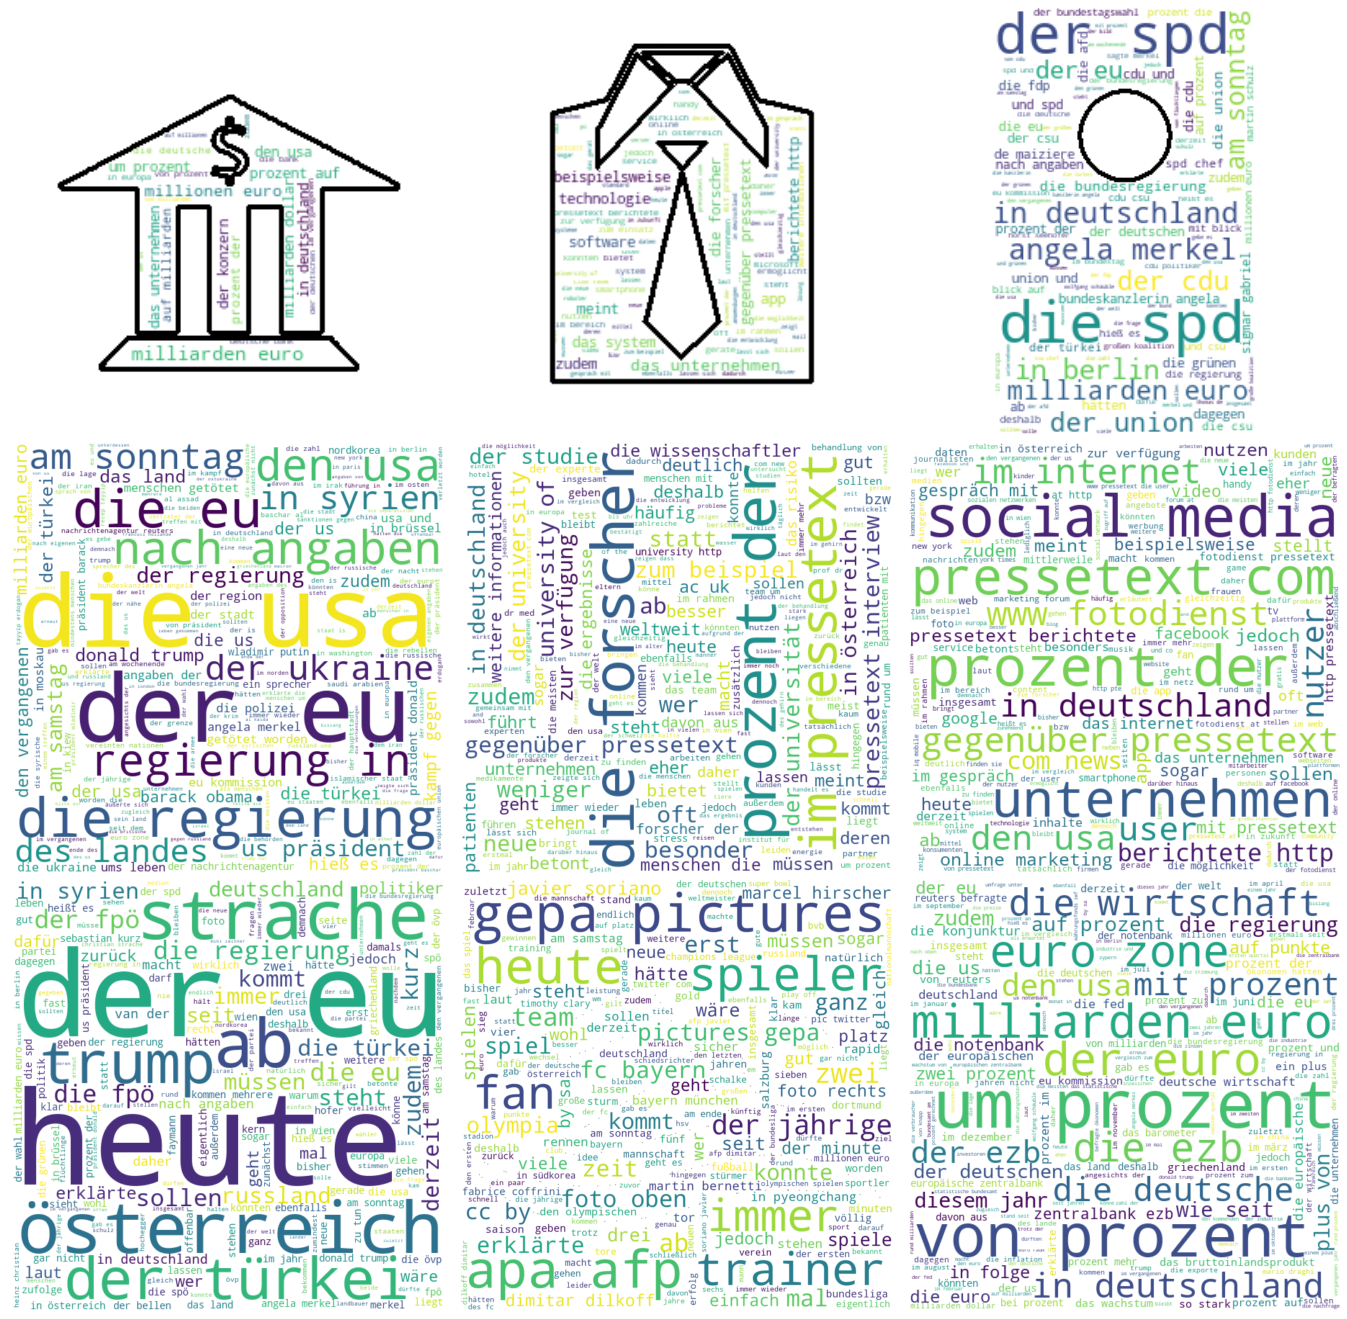

In [200]:
# Create a word cloud image
stopset = set(stopwords.words('german'))
stopset.update(["http","www","au","al","bi","sowie","etwa","dabei","die","der","seien"
                ,"un","de","sei","mehr","als","gibt","es","ja","schon","wurde","wa","sagte"
               ,"schon","hatte","den","am","erklärt","montag","dienstag","mittwoch","donnerstag","freitag"
               ,"bereit","sagt","wurden","allerdings","beim","von","wegen","allerding"])

def gen_wordcloud(input_mask, text):
    wordcloud = WordCloud(background_color="white", max_words=200, mask=input_mask,
               stopwords=stopset, contour_width=3, contour_color='black')
    # Generate a wordcloud
    wordcloud.generate(text)
    return wordcloud

business_wordcloud      = gen_wordcloud(transformed_business_mask, text_clear_business)
hightech_wordcloud      = gen_wordcloud(transformed_hightech_mask, text_clear_hightech)
inland_wordcloud        = gen_wordcloud(transformed_inland_mask, text_clear_inland)
international_wordcloud = gen_wordcloud(transformed_international_mask, text_clear_international)
leben_wordcloud         = gen_wordcloud(transformed_leben_mask, text_clear_leben)
medien_wordcloud        = gen_wordcloud(transformed_medien_mask, text_clear_medien)
politik_wordcloud       = gen_wordcloud(transformed_politik_mask, text_clear_politik)
sport_wordcloud         = gen_wordcloud(transformed_sport_mask, text_clear_sport)
wirtschaft_wordcloud    = gen_wordcloud(transformed_wirtschaft_mask, text_clear_wirtschaft)




# store to file
#wc.to_file("Imgages/business.png")

# show
cat_cl = [business_wordcloud, hightech_wordcloud, inland_wordcloud, international_wordcloud, leben_wordcloud
       , medien_wordcloud, politik_wordcloud, sport_wordcloud, wirtschaft_wordcloud]
fig, axes = plt.subplots(3,3,figsize=(24,24),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(cat_cl[i], interpolation='bilinear')
    ax.axis("off")

### Is there a Gender Bias in the Categories?

Analyse, whether some categories tend to write more about man or woman. In the German language this is difficult to distinguish. As a first step, the number of "sie" ("she") and "er" ("he") are counted for each category. However, this does not give a sophisticated value for a gender bias, since all plural nouns are addressed with "sie" aswell and also other things (not people) have a gender. However eye-catching is that for the category "Leben" ("life") is much more usage of the word "sie" than in all other categories. 

In [201]:
#Is there a difference between numbers of "er" und "sie" (oder ähnliches) in den Kategorien

# "er", "sie" nicht geeignet, was könnte man sonst nehmen?

def count_er_sie(text):
    count_sie = 0
    count_er  = 0
    for i in text.split():
        if i == "sie":
            count_sie+=1
        if i == "er":
            count_er+=1
    return count_sie, count_er

In [202]:
count_business_sie, count_business_er = count_er_sie(text_clear_business)
print("Number of 'sie' occurrences in 'Business': {}".format(count_business_sie))
print("Number of 'er' occurrences in 'Business': {}".format(count_business_er))
count_hightech_sie, count_hightech_er = count_er_sie(text_clear_hightech)
print("Number of 'sie' occurrences 'Hightech': {}".format(count_hightech_sie))
print("Number of 'er' occurrences 'Hightech': {}".format(count_hightech_er))
count_inland_sie, count_inland_er = count_er_sie(text_clear_inland)
print("Number of 'sie' occurrences 'Inland': {}".format(count_inland_sie))
print("Number of 'er' occurrences 'Inland': {}".format(count_inland_er))
count_international_sie, count_international_er = count_er_sie(text_clear_international)
print("Number of 'sie' occurrences 'International': {}".format(count_international_sie))
print("Number of 'er' occurrences 'International': {}".format(count_international_er))
count_leben_sie, count_leben_er = count_er_sie(text_clear_leben)
print("Number of 'sie' occurrences in 'Leben': {}".format(count_leben_sie))
print("Number of 'er' occurrences in 'Leben': {}".format(count_leben_er))
count_medien_sie, count_medien_er = count_er_sie(text_clear_medien)
print("Number of 'sie' occurrences in 'Medien': {}".format(count_medien_sie))
print("Number of 'er' occurrences in 'Medien':{}".format(count_medien_er))
count_politik_sie, count_politik_er = count_er_sie(text_clear_politik)
print("Number of 'sie' occurrences in 'Politik': {}".format(count_politik_sie))
print("Number of 'er' occurrences in 'Politik': {}".format(count_politik_er))
count_sport_sie, count_sport_er = count_er_sie(text_clear_sport)
print("Number of 'sie' occurrences in 'Sport': {}".format(count_sport_sie))
print("Number of 'er' occurrences in 'Sport': {}".format(count_sport_er))
count_wirtschaft_sie, count_wirtschaft_er = count_er_sie(text_clear_wirtschaft)
print("Number of 'sie' occurrences in 'Wirtschaft': {}".format(count_wirtschaft_sie))
print("Number of 'er' occurrences in 'Wirtschaft': {}".format(count_wirtschaft_er))

Number of 'sie' occurrences in 'Business': 13212
Number of 'er' occurrences in 'Business': 9227
Number of 'sie' occurrences 'Hightech': 5397
Number of 'er' occurrences 'Hightech': 2207
Number of 'sie' occurrences 'Inland': 7868
Number of 'er' occurrences 'Inland': 7909
Number of 'sie' occurrences 'International': 11879
Number of 'er' occurrences 'International': 14258
Number of 'sie' occurrences in 'Leben': 10707
Number of 'er' occurrences in 'Leben': 2500
Number of 'sie' occurrences in 'Medien': 6367
Number of 'er' occurrences in 'Medien':1889
Number of 'sie' occurrences in 'Politik': 3192
Number of 'er' occurrences in 'Politik': 4193
Number of 'sie' occurrences in 'Sport': 717
Number of 'er' occurrences in 'Sport': 1043
Number of 'sie' occurrences in 'Wirtschaft': 6986
Number of 'er' occurrences in 'Wirtschaft': 4686


In [203]:
#save as dataframe
categories = ["Business", "Hightech", "Inland", "International", "Leben", "Medien", "Politik", "Sport", "Wirtschaft"]
data = {"Kategorie": categories, "sie": None, "er": None}
er_sie_df = pd.DataFrame (data, columns = ["Kategorie", "sie", "er"]).set_index("Kategorie")

er_sie_df.loc["Business","sie"] = count_business_sie
er_sie_df.loc["Business","er"] = count_business_er
er_sie_df.loc["Hightech","sie"] = count_hightech_sie
er_sie_df.loc["Hightech","er"] = count_hightech_er
er_sie_df.loc["Inland","sie"] = count_inland_sie
er_sie_df.loc["Inland","er"] = count_inland_er
er_sie_df.loc["International","sie"] = count_international_sie
er_sie_df.loc["International","er"] = count_international_er
er_sie_df.loc["Leben","sie"] = count_leben_sie
er_sie_df.loc["Leben","er"] = count_leben_er
er_sie_df.loc["Medien","sie"] = count_medien_sie
er_sie_df.loc["Medien","er"] = count_medien_er
er_sie_df.loc["Politik","sie"] = count_politik_sie
er_sie_df.loc["Politik","er"] = count_politik_er
er_sie_df.loc["Sport","sie"] = count_sport_sie
er_sie_df.loc["Sport","er"] = count_sport_er
er_sie_df.loc["Wirtschaft","sie"] = count_wirtschaft_sie
er_sie_df.loc["Wirtschaft","er"] = count_wirtschaft_er
er_sie_df

,sie,er
Kategorie,,
Business,13212,9227
Hightech,5397,2207
Inland,7868,7909
International,11879,14258
Leben,10707,2500
Medien,6367,1889
Politik,3192,4193
Sport,717,1043
Wirtschaft,6986,4686


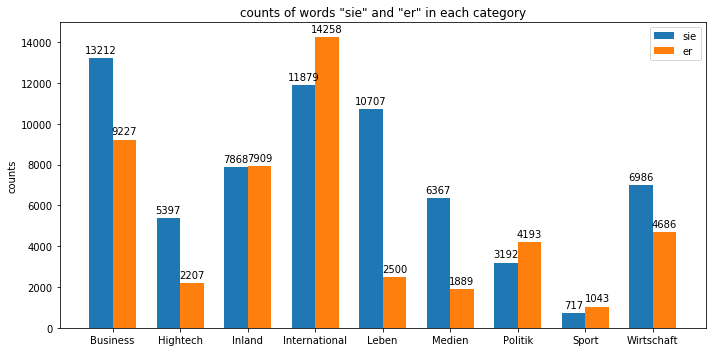

In [204]:
labels = ['Business', 'Hightech', 'Inland', 'International', 'Leben', 'Medien', 'Politik', 'Sport', 'Wirtschaft']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, er_sie_df['sie'], width, label='sie')
rects2 = ax.bar(x + width/2, er_sie_df['er'], width, label='er')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('counts')
ax.set_title('counts of words "sie" and "er" in each category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Time development

What is the distribution over time? For which time period do we have data and is it equally distributed? The barplot shows the number of articles we have for each year. From 2013 on we have more data available. 

In [205]:
news_cat["Datum"].unique()

array(['2018-01-18 00:00:00', '2018-01-17 00:00:00',
       '2018-01-12 00:00:00', ..., '2018-03-02 00:00:00',
       '2018-02-17 00:00:00', '2018-02-03 00:00:00'], dtype=object)

In [206]:
for i in range(news_cat.shape[0]):
    datetime.strptime(news_cat["Datum"][i],'%Y-%m-%d %H:%M:%S')
news_cat.head()

,index,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Body_length
0,0,773233,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,Wirtschaft,2018-01-18 00:00:00,Postillion,1,160.0
1,1,773234,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,Wirtschaft,2018-01-17 00:00:00,Postillion,1,248.0
2,2,773235,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",Wirtschaft,2018-01-12 00:00:00,Postillion,1,264.0
3,3,773236,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,Wirtschaft,2018-01-09 00:00:00,Postillion,1,290.0
4,4,773237,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,Wirtschaft,2018-01-08 00:00:00,Postillion,1,163.0


In [142]:
for i in range(news_cat.shape[0]):
    pd.to_datetime(news_cat.loc[i,'Datum'])
news_cat.head()

,index,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake,Body_length
0,0,773233,http://www.der-postillon.com/2018/01/grokoleak...,Exklusiv! Das geheime WhatsApp-Chat-Protokoll ...,Die Sondierungsgespräche zwischen Union und SP...,Wirtschaft,2018-01-18 00:00:00,Postillion,1,160.0
1,1,773234,http://www.der-postillon.com/2018/01/trump-san...,"Trump droht, jeden zu verspeisen, der an seine...",Nun ist es auch medizinisch offiziell bestätig...,Wirtschaft,2018-01-17 00:00:00,Postillion,1,248.0
2,2,773235,http://www.der-postillon.com/2018/01/fdp-sondi...,"Soli runter, keine Steuererhöhungen, kein Klim...","Es waren zähe Verhandlungen, doch die Freien D...",Wirtschaft,2018-01-12 00:00:00,Postillion,1,264.0
3,3,773236,http://www.der-postillon.com/2018/01/joachim-s...,Hat sie eine Affäre? Joachim Sauer glaubt Ange...,Wo treibt sie sich immer bis spät in die Nacht...,Wirtschaft,2018-01-09 00:00:00,Postillion,1,290.0
4,4,773237,http://www.der-postillon.com/2018/01/halb-so-s...,"""Er hat ja nur HALBneger gesagt"": So begründet...",Der Parteivorstand drückt nochmal ein Auge zu:...,Wirtschaft,2018-01-08 00:00:00,Postillion,1,163.0


In [213]:
# change type of "Datum" to DatetimeIndex
news_cat['Datum'] = pd.DatetimeIndex(news_cat['Datum'])

In [ ]:
# set "Datum" as index
news_cat.set_index("Datum", inplace=True)

In [225]:
# count articles per year
news_cat.resample('Y')["index"].count()

Datum
2008-12-31     2505
2009-12-31     2933
2010-12-31     2817
2011-12-31     3124
2012-12-31     2941
2013-12-31    10107
2014-12-31     8133
2015-12-31     7641
2016-12-31     8647
2017-12-31     8943
2018-12-31     4755
Freq: A-DEC, Name: index, dtype: int64

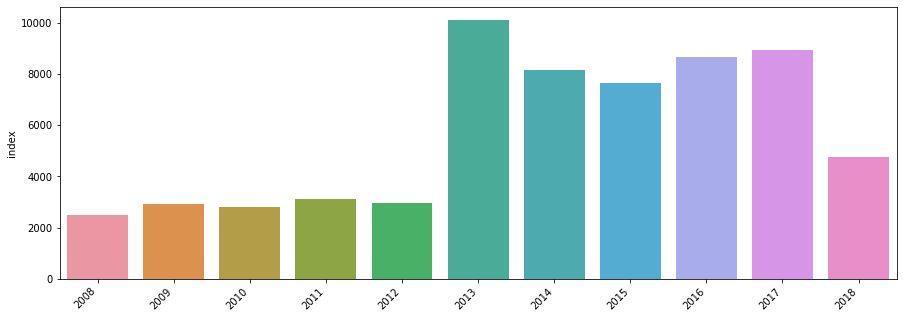

In [227]:
yrs = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
plt.figure(figsize=(15,5))
#chart = sns.barplot(x=mean_words["Kategorie"],y=mean_words["Body_length"]);
chart = sns.barplot(x= yrs,y=news_cat.resample('Y')["index"].count());
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');
#sns.countplot(news_cat.resample('M')["index"].count());

# Feature Engeneering

1. For the prediction fake vs. no fake, the target is already given in the dataframe. Use the news_fake dataframe for predective modelling and the column "Fake" as a target. Use the columns "Titel" and "Body" as features.

2. For the second objective, we further want to distinguish between the categories in the prediction. That is, we will create a new column indicating the category and whether it is fake or not. Since we consider 9 categories, this feature would have 18 classes. As a first step we will create this column and have a look how many observations we have for each class. We then concentrate on the most important categories. The rest goes to the category "Andere".

## Fake vs. no Fake Prediction: 

### Define the target classes

We have seen that the two categories are very unbalanced. We therefore downsample the no-fake category. After that we are left with 4627 fake and 4627 no-fake observations. Then we perform a train test split.

Random under-sampling:
1    4627
0    4627
Name: Fake, dtype: int64


1    3705
0    3698
Name: Fake, dtype: int64

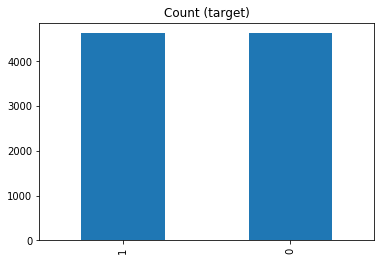

In [232]:
#sampling

# Class count
count_class_0, count_class_1 = news_fake["Fake"].value_counts()

# Divide by class
news_fake_class_0 = news_fake[news_fake['Fake'] == 0]
news_fake_class_1 = news_fake[news_fake['Fake'] == 1]

news_fake_class_0_under = news_fake_class_0.sample(count_class_1)
news_fake_test_under = pd.concat([news_fake_class_0_under, news_fake_class_1], axis=0)

print('Random under-sampling:')
print(news_fake_test_under.Fake.value_counts())

news_fake_test_under.Fake.value_counts().plot(kind='bar', title='Count (target)');
text_train, text_test, y_train, y_test = train_test_split(news_fake_test_under["Titel"]+news_fake_test_under["Body"], news_fake_test_under["Fake"], test_size=0.2, random_state=42)
y_train.value_counts()

In [233]:
news_fake_test_under.head()

,index,id,url,Titel,Body,Kategorie,Datum,Quelle,Fake
63822,63822,838101,http://www.kleinezeitung.at//leute/5372614/Wie...,Jetzt ist es fix: Helene Fischer tritt am Frei...,Das Management von Helene Fischer gab grünes L...,Leute,2018-02-15 00:00:00,Kleine,0
14928,14928,788334,https://de.reuters.com/article/m-rkte-fernost-...,Erneut sinkende Ölpreise drücken Kurse an Asie...,Der wieder fallende Ölpreis hat am Dienstag au...,Marktnachrichten,2016-01-26 00:00:00,Reuters,0
16473,16473,789903,https://de.reuters.com/article/syrien-usa-russ...,Kerry schlägt Außenministertreffen zu Syrien d...,Mit einem neuen diplomatischen Vorstoß wollen ...,International,2015-10-19 00:00:00,Reuters,0
32287,32287,805942,https://de.reuters.com/article/usa-bip-idDEBEE...,US-Wirtschaft wächst etwas schneller als bisla...,Die US-Wirtschaft ist im vierten Quartal etwas...,Wirtschaft,2013-03-28 00:00:00,Reuters,0
30260,30260,803892,https://de.reuters.com/article/gsw-top-idDEBEE...,Investoren gewinnen Machtkampf bei GSW - Chefs...,Der Machtkampf beim Berliner Wohnungskonzern G...,Business,2013-06-26 00:00:00,Reuters,0


### Vectorize Text 

In [242]:
vect = CountVectorizer(ngram_range=(1, 2),stop_words=None,lowercase=True,max_df=0.8, min_df=20)
tfidf = TfidfTransformer()

In [243]:
pipe_lr = Pipeline([
    ('vect',vect),
    ('tfidf',tfidf)
    ])

In [244]:
pipe_lr.fit(text_train, y_train)
print(len(vect.vocabulary_))

17216


In [261]:
text_transform_train = pipe_lr.transform(text_train).toarray();
text_transform_test = pipe_lr.transform(text_test).toarray();

## Category Prediction

Define a new column, that has 18 classes. Each class divides the observations in category and fake vs. no fake. E.g. class 1: Business, no fake, class 2: Business, fake, etc.

Remeber the categories: 'Business', 'Hightech', 'Inland', 'International', 'Leben', 'Medien', 'Politik', 'Sport', 'Wirtschaft'

In [262]:
#text_train_cat, text_test_cat, y_train_cat, y_test_cat = train_test_split(news_cat["Titel"]+news_cat["Body"], news_cat["Fake"], test_size=0.2, random_state=42)
#y_train.value_counts()

# Predictive modelling

standardize(?)

define a set of models

cross validation

evaluate metrics

define final model

hyperparamter tuning

evaluation

In [263]:
# Define a list of possible models
clfs = [LogisticRegression(solver="lbfgs", random_state=42)
       , KNeighborsClassifier(n_neighbors= 15)#
       , GaussianNB()
       , SVC(C=10, random_state=42, gamma=0.001)#C=1, kernel="rbf", gamma='scale', random_state=42)
       , LinearSVC(random_state=42)
       , RandomForestClassifier(n_estimators=500, criterion="gini", max_depth=5, random_state=42)
       , AdaBoostClassifier(random_state=42)
       , XGBClassifier(random_state=42)]

In [264]:
# Function that performs cross validation and returns the desired metric(s)
# The metrics are stored in a dictionary
def model_evaluation_cv(X_train, y_train, clf, params_model=None, 
                     params_cross={"cv":5, "scoring":['accuracy','precision','recall','roc_auc','f1']}):
    # cross validation
    scores = cross_validate(clf, X_train, y_train, **params_cross)
    #print(scores)
    # return the list of all dictionary keys with mean values (mean over metrics from folds) 
    scores = {key: value.mean() for (key, value) in scores.items()}

    return scores

In [265]:
# Perform the model evaluation for all models in clf and cross folds
# Save the results in a dictionary, as follows: results ={'clf': {metrics}}
#kfold=5
results = {}
for clf in clfs:
    clf_name = clf.__class__.__name__
    print(clf_name)
    scores = model_evaluation_cv(X_train = text_transform_train, y_train = y_train, clf = clf)
    results[clf_name] = scores        
print(results)

LogisticRegression
KNeighborsClassifier
GaussianNB
SVC
LinearSVC
RandomForestClassifier
AdaBoostClassifier
XGBClassifier
{'LogisticRegression': {'fit_time': 8.074522781372071, 'score_time': 0.16010003089904784, 'test_accuracy': 0.9771711042575323, 'test_precision': 0.9709835620113723, 'test_recall': 0.9838056680161944, 'test_roc_auc': 0.9958855915625376, 'test_f1': 0.9773464857547081}, 'KNeighborsClassifier': {'fit_time': 15.225807809829712, 'score_time': 910.4634244441986, 'test_accuracy': 0.894098125809807, 'test_precision': 0.9394462498344369, 'test_recall': 0.8429149797570851, 'test_roc_auc': 0.9628406395032704, 'test_f1': 0.8884522654018857}, 'GaussianNB': {'fit_time': 6.059258317947387, 'score_time': 2.190470552444458, 'test_accuracy': 0.9331352993777031, 'test_precision': 0.9388305811821299, 'test_recall': 0.9268556005398111, 'test_roc_auc': 0.9337041348514891, 'test_f1': 0.9327589277437551}, 'SVC': {'fit_time': 4376.726148414612, 'score_time': 3266.438644170761, 'test_accuracy'

In [266]:
# Function for the plots
# "results" is the dictionary containing the scores
# Remember: results = {'clf': {'cross_fold': {metrics}}

def plot_results(scores_mean, legend_labels, title='Model Comparison'):
    width = 0.5
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_facecolor((1.0, 250/255, 234/255))
    clfs = list(scores_mean.keys())
    x = np.arange(0, (len(clfs)+1)*(len(legend_labels)-2), len(clfs)+1)
    for clf in clfs:        
        score_list = []
        x+=1
        for score in scores_mean[clf]:
            if (score!="fit_time") and (score!="score_time"):
                #score_list contains all scores for one model
                score_list.append(scores_mean[clf][score])
        rects1 = ax.bar(x - width/2, score_list, width, label=clf, alpha=1)
        ax.set_ylabel('score')
        ax.set_title(title)
        ax.set_ylim(0.5,1)
        ax.set_xticks(x-len(clfs)/2)
        ax.set_xticklabels(score_labels[2:])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True)

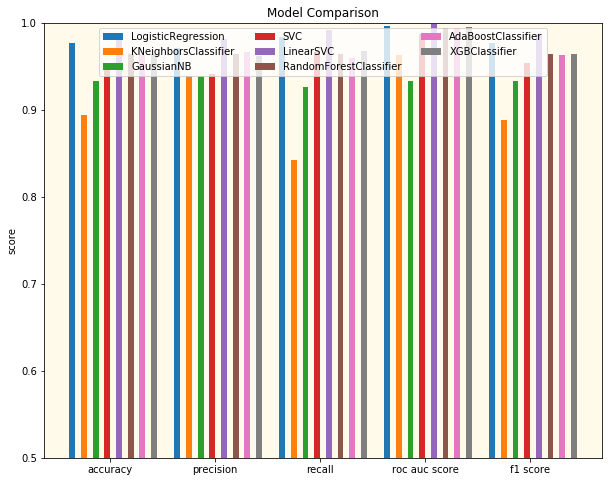

In [267]:
score_labels = ["fit time", "score time", "accuracy", "precision", "recall", "roc auc score", "f1 score"]
plot_results(results, score_labels)

In [ ]:
#for clf in clfs:
pipe_lr = Pipeline([
    ('vect',vect),
    ('tfidf',tfidf),
    ('clf',clf)
    ])
pipe_lr.fit(text_train, y_train)
print(len(vect.vocabulary_))

# Visualization

# Future Work